In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel,PDE
from sciann.utils import *
import scipy.io 
import time
import random
from mpl_toolkits.mplot3d import Axes3D

from eikonalfm import factored_fast_marching as ffm
from eikonalfm import distance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

2024-07-07 16:17:52.573662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 16:17:52.710035: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 16:17:52.748488: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 16:17:53.231422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.1 
Python Version: 3.8.16 (default, Jun 12 2023, 18:09:05) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


In [2]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[-1], 'GPU')
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
mat_data = scipy.io.loadmat('./3Dvelocity/velocity_3d.mat')
vp = mat_data['v']
vs = vp/1.731

nz = vp.shape[0]
nx = vp.shape[1]
ny = vp.shape[2]

In [5]:
ymin = 0.; dy = 0.025; ymax = (ny-1)*dy;
xmin = 0.; dx = 0.025; xmax = (nx-1)*dx;
zmin = 0.; dz = 0.025; zmax = (nz-1)*dz;

d=[dz,dx,dy] 
order = 2

In [6]:
num = 50
step = 0.025
rx = np.round(np.round(np.random.uniform(xmin, xmax, num) / step) * step, 3).reshape(-1, 1)
ry = np.round(np.round(np.random.uniform(ymin, ymax, num) / step) * step, 3).reshape(-1, 1)
rz = np.round(np.round(np.random.uniform(zmin, zmax, num) / step) * step, 3).reshape(-1, 1)

In [7]:
z_n = (rz / dz).astype(int)
x_n = (rx / dx).astype(int)
y_n = (ry / dy).astype(int)

In [8]:
#zhenyuanduiyingzoushi
Tp_ref = np.zeros((nz,nx,ny,num))
Ts_ref = np.zeros((nz,nx,ny,num))
for i in range(num):
    star = np.array([z_n[i], x_n[i], y_n[i]]).flatten()
    Tp_ref[:,:,:,i] = ffm(vp, star, d, order) * distance(vp.shape, d, star, indexing='ij')
    Ts_ref[:,:,:,i] = ffm(vs, star, d, order) * distance(vs.shape, d, star, indexing='ij')

In [9]:
np.savez('random_coordinates.npz', rx=rx, ry=ry, rz=rz)
np.save('Tp_suiji.npy',Tp_ref)
np.save('Ts_suiji.npy',Ts_ref)

In [22]:
print(rx.shape)

(50, 1)


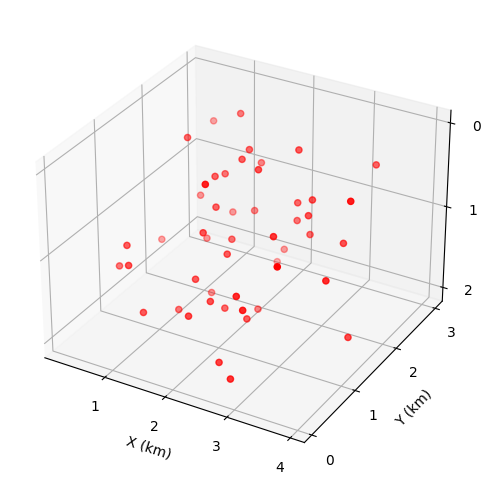

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot( projection='3d')
ax.scatter(rx, ry, rz, c='r', marker='o')

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.zaxis.set_major_locator(plt.MultipleLocator(1))

plt.gca().invert_zaxis()
plt.savefig("./Fig/over3d_sources.jpeg", format='jpeg', bbox_inches="tight",dpi=400)

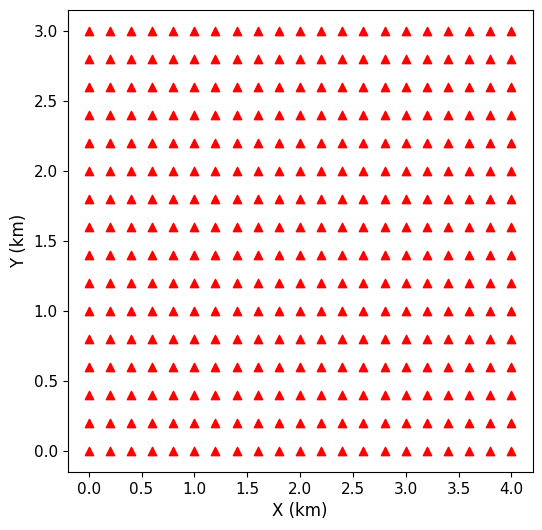

In [21]:
ix = np.round(np.arange(0,4.01,0.2),2)
iy = np.round(np.arange(0,3.01,0.2),2)

iX,iY= np.meshgrid(ix,iy,indexing='ij')
iX,iY= np.meshgrid(ix,iy,indexing='ij')

fig = plt.figure(figsize=(6,6))
plt.scatter(iX.reshape(-1,1), iY.reshape(-1,1), c='r', marker='^')

plt.xlabel('X (km)', fontsize=12)
plt.xticks(fontsize=11)

plt.ylabel('Y (km)', fontsize=12)
plt.yticks(fontsize=11)

plt.savefig("./Fig/over2d_receivers.jpeg", format='jpeg', bbox_inches="tight",dpi=400)